In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.scale import LogScale
import json
from utils import dref_dataframe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

def parse_logs(path: Path, iter: int = 1) -> pd.DataFrame:
    meta = json.load((path / f"meta.json").open())
    data = pd.read_csv(path / "out.csv")
    data["iter"] = data.index
    data["shrink"] = (data["shrink"] / 1e9) / meta["args"]["mem"]
    data["grow"] = (data["grow"] / 1e9) / meta["args"]["mem"]
    if "touch" in data.columns:
        data["touch"] = (data["touch"] / 1e9) / (meta["args"]["mem"] - 1)

    match path.stem:
        case n if n.endswith("base-manual"): mode = "virtio-balloon"
        case n if n.endswith("huge-manual"): mode = "virtio-balloon-huge"
        case n if n.endswith("virtio-mem-movable"): mode = "virtio-mem"
        case n if n.endswith("virtio-mem-movable-vfio"): mode = "virtio-mem+VFIO"
        case n if n.endswith("llfree-manual"): mode = "HyperAlloc"
        case n if n.endswith("llfree-manual-vfio"): mode = "HyperAlloc+VFIO"
        case m: mode = m
    data["mode"] = mode
    return pd.DataFrame(data)


     shrink      grow     touch      touch2  iter                 mode  \
1  1.057603  0.426887  1.031537  1290010624     1       virtio-balloon   
2  1.050183  0.427368  1.016332  2380791808     2       virtio-balloon   
3  1.043587  0.427922  1.047265  2465464320     3       virtio-balloon   
4  1.035610  0.426925  1.045430  1304952832     4       virtio-balloon   
5  1.061880  0.427211  1.019740  1808007168     5       virtio-balloon   
6  1.047812  0.425725  1.012924  2779250688     6       virtio-balloon   
7  1.054956  0.425992  1.043071  1558970368     7       virtio-balloon   
8  1.048790  0.425588  1.014235  2400714752     8       virtio-balloon   
9  1.059253  0.425669  1.043071  1344798720     9       virtio-balloon   
1  0.007077  0.003051  0.233570  1110704128     1  virtio-balloon-huge   
2  0.007429  0.003076  0.231735  1115684864     2  virtio-balloon-huge   
3  0.007572  0.003074  0.235143  1105723392     3  virtio-balloon-huge   
4  0.007203  0.003074  0.232522  11107

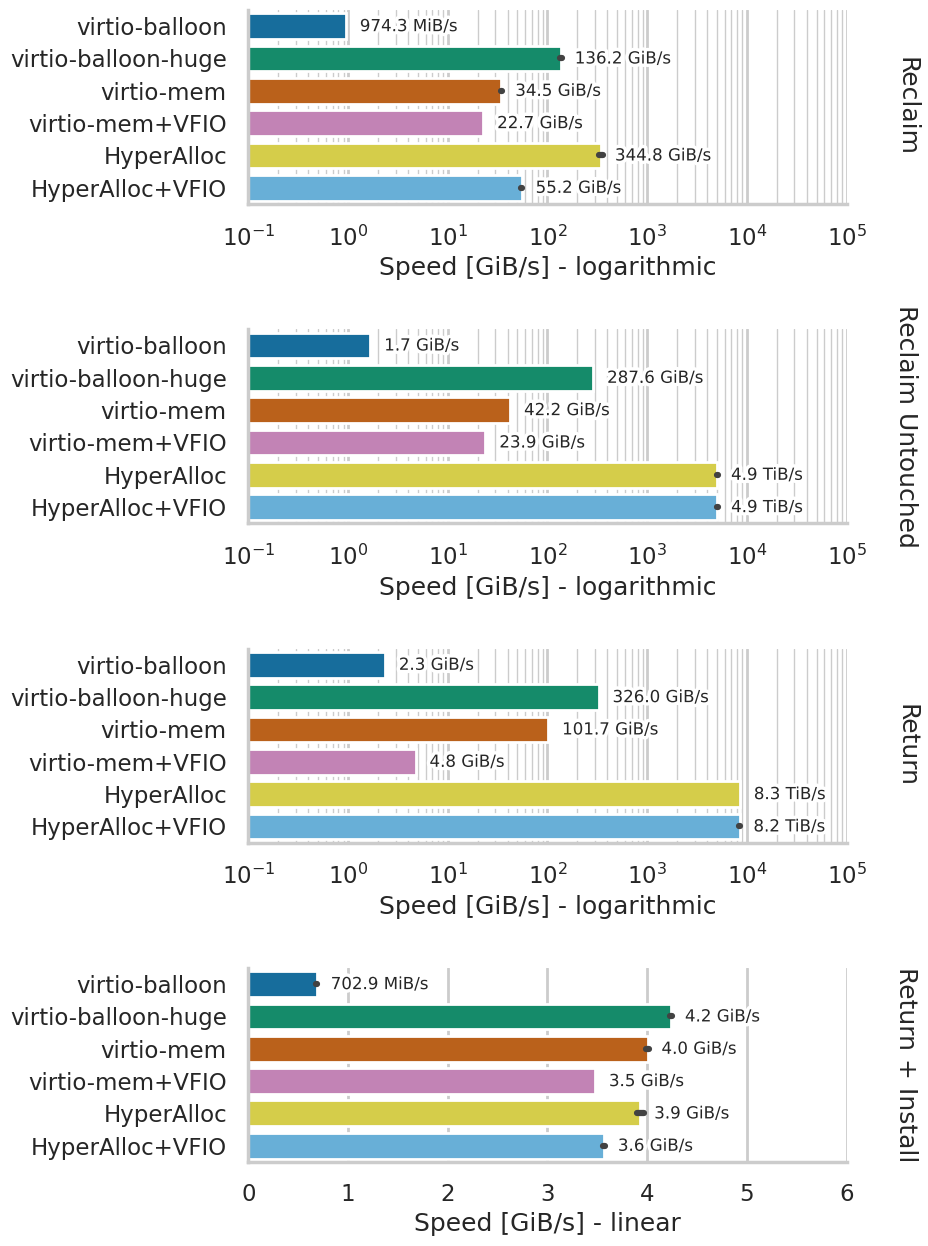

In [2]:
# Touched
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
data = data[data["iter"] > 0]
data["install"] = data["touch"] + data["grow"]
print(data)

pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow", "touch", "install"],
                var_name="op", value_name="time")
pgd["time"] = 1 / pgd["time"]

# Untouched
paths = [
    Path("inflate/latest-nofault-base-manual"),
    Path("inflate/latest-nofault-huge-manual"),
    Path("inflate/latest-nofault-virtio-mem-movable"),
    Path("inflate/latest-nofault-virtio-mem-movable-vfio"),
    Path("inflate/latest-nofault-llfree-manual"),
    Path("inflate/latest-nofault-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
data = data[data["iter"] > 0]
print(data)

pgd1 = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
pgd1["time"] = 1 / pgd1["time"]
pgd1 = pgd1[pgd1["op"] == "shrink"]
pgd1["op"] = "Reclaim Untouched"

# Both
pgd = pd.concat([pgd, pgd1])
pgd.loc[pgd["op"] == "shrink", "op"] = "Reclaim"
pgd.loc[pgd["op"] == "grow", "op"] = "Return"
pgd.loc[pgd["op"] == "install", "op"] = "Return + Install"
pgd.loc[pgd["op"] == "touch", "op"] = "Install"
print(pgd["op"].unique())

print(pgd["time"].max())
order = ["virtio-balloon","virtio-balloon-huge","virtio-mem","virtio-mem+VFIO","HyperAlloc","HyperAlloc+VFIO"]
p = sns.FacetGrid(pgd, row="op", margin_titles=True,
                  row_order=["Reclaim", "Reclaim Untouched", "Return", "Return + Install"],
                  aspect=3, height=3.2, sharex=False)

p.map_dataframe(sns.barplot, y="mode", hue="mode", hue_order=order,
                palette="colorblind6", x="time", dodge=False)
p.set(ylabel=None)

def mem_fmt(x: float) -> str:
    x *= 1024**3
    sizes = ["TiB", "GiB", "MiB", "KiB"]
    for i, suffix in enumerate(sizes):
        mul = 1024 ** (len(sizes) - i)
        if x > mul: return f"{x/mul:.1f} {suffix}/s"
    return f"{x:.2} B/s"

for key, ax in p.axes_dict.items():
    if key != "Return + Install":
        ax.set(xlim=(1e-1, 1e5))
        ax.set_xscale("log", base=10)
        ax.set(xlabel="Speed [GiB/s] - logarithmic")
    else:
        ax.set(xlim=(0, 6))
        ax.set(xlabel="Speed [GiB/s] - linear")

    ax.grid(True, which="minor", linewidth=1)
    for c in ax.containers:
        ax.bar_label(c, fmt=mem_fmt, fontsize=12, padding=10,
                     path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])
p.set_titles(row_template="{row_name}", xytext=(1.08, 0.5))
p.figure.savefig("inflate/inflate.pdf", bbox_inches="tight")
p.figure.savefig("inflate/inflate.svg", bbox_inches="tight")
dref_dataframe("inflate", Path("inflate"), ["mode", "iter", "op"], pgd)